# APS fly scans with taxi & fly `busy` records

Some EPICS fly scans at APS are triggered by a pair of EPICS
[*busy*](https://epics-modules.github.io/busy/) records.  
Each *busy* record initates a sequence of EPICS processing
steps as defined by other EPICS records.  The first *busy*
record is called `taxi` and is responsible for preparing the hardware to fly.
Once *taxi* is complete, the second *busy* record, called `fly`, performs the
actual fly scan.

The next figure shows a control screen (from an APS beam line). The screen has
buttons to initiate taxi & fly sequences. Controls for some other scan
parameters are also shown.

![taxi/fly control screen](../_static/1ide-taxi-fly-screen.png)

In a third (optional) phase, data is collected from hardware
and written somewhere (in this example, to the databroker catalog).  

This document shows how to operate such a scan with two examples.  
We'll refer to *taxi* and *fly* as phases.

- simplified processing sequence for each phase
  - shows the basic flow of control
  - sequence: delay a short time, then return
  - no data collection
- step scan of scaler *v*. motor
  - includes data collection
  - additional PVs recorded
  - plot saved data
  - typical use case for APS beamlines

## Overview

Compare the taxi & fly scan algorithm to an airplane flight:

phase | airplane flight | taxi & fly scan
--- | --- | ---
preparation | ticketing, boarding, baggage handling | configuration of software
taxi | move the aircraft to the start of the runway | move the hardware to pre-scan positions
fly | start moving, liftoff at flight velocity | start moving, begin collecting data at first position
data | baggage claim | retrieve the fly scan data arrays

## Bluesky (Python) setup

These packages are needed to begin.  The first block contains Python standard
packages, then come the various bluesky packages.  Just the parts we plan on
using here.

* Create a logger instance in case we want to investigate internal details as our code runs.
* Create an instance of the bluesky `RunEngine`.
* Create a temporary databroker catalog to save collected data.
* Subscribe the catalog to receive all data published by the RunEngine.

In [1]:
import logging
import time

from apstools.synApps import BusyRecord
from apstools.plans import run_blocking_function
import bluesky
import bluesky.plan_stubs as bps
import databroker
from ophyd import Component, Device, Signal

logger = logging.getLogger()
logger.setLevel(logging.INFO)

RE = bluesky.RunEngine()
cat = databroker.temp().v2
RE.subscribe(cat.v1.insert)
print(f"{cat=}")

cat=<Intake catalog: temp>


## EPICS IOC

We'll start with an EPICS IOC that provides two instances of the
[*busy*](https://epics-modules.github.io/busy/) record.

In the `gp:` IOC, we can use these general purpose PVs for this example:

PV | record | purpose
--- | --- | ---
`gp:mybusy1` | *busy* | taxi (preparation) phase
`gp:mybusy2` | *busy* | fly (fly scan) phase

Here, an ophyd `Device` subclass coordinates both *busy* records.

The `BusyRecord` class from
[apstools.devices](https://bcda-aps.github.io/apstools/latest/api/synApps/index.html#records)
provides a standard interface to the synApps `busy` record.  We subclass `BusyRecord`
here as `MyBusyRecord` and redefine the `.trigger()` method, as advised by this
[bluesky tutorial](https://blueskyproject.io/tutorials/Ophyd/02%20-%20Complex%20Behaviors%20%28Set%20and%20Multiple%20PVs%29.html).
A `DeviceStatus` object is returned to monitor the progress of the busy
record.

Handling of the `taxi` and `fly` phases is identical.  A complete taxi/fly scan
is performed by the `taxi_fly_plan()` method.  Note this method is a bluesky
plan. It should be run by the bluesky RunEngine.

Also note that, as written, the `taxi_fly_plan()` method does not collect any
data.  As such, it should be considered as a part of a bluesky
[plan](https://blueskyproject.io/bluesky/plans.html#plans) which [opens a
run](https://blueskyproject.io/bluesky/generated/bluesky.plan_stubs.open_run.html#bluesky.plan_stubs.open_run)
and ([triggers
and](https://blueskyproject.io/bluesky/generated/bluesky.plan_stubs.trigger_and_read.html#bluesky.plan_stubs.trigger_and_read))
[reads](https://blueskyproject.io/bluesky/generated/bluesky.plan_stubs.read.html)
data from one or more
[Signals](https://blueskyproject.io/ophyd/user/reference/signals.html) or
[Devices](https://blueskyproject.io/ophyd/user/tutorials/device.html).

In [2]:
from ophyd import DeviceStatus

class MyBusyRecord(BusyRecord):
    timeout = Component(Signal, value=10, kind="config")

    def trigger(self):
        """
        Start this busy record.  Return DeviceStatus to monitor completion.

        (Actual value of '_ignored' argument will not be used.)
        This method is called from 'bps.trigger(busy, wait=True)'.
        """
        status = DeviceStatus(self, timeout=self.timeout.get())

        def watch_state(old_value, value, **kwargs):
            if old_value in (1, "Busy") and value not in (1, "Busy"):
                # When busy finishes, state changes from 1 to 0.
                status.set_finished()
                self.state.clear_sub(watch_state)

        # Push the Busy button...
        self.state.put("Busy")
        # Start a CA monitor on self.state, call watch_state() with updates.
        self.state.subscribe(watch_state)

        # And return the DeviceStatus object.
        # The caller can use it to tell when the action is complete.
        return status

class TaxiFlyScanDevice(Device):
    taxi = Component(MyBusyRecord, "mybusy1", kind="config")
    fly = Component(MyBusyRecord, "mybusy2", kind="config")

    def taxi_fly_plan(self):
        yield from bps.trigger(self.taxi, wait=True)
        yield from bps.trigger(self.fly, wait=True)

## The `busy` record

Summary: The *busy* record tells the *sseq* record to do all its processing
steps.  The *sseq* record waits its assigned time, then turns the *busy* record
off.

The *busy* record has a very limited task. It signals the procedure should start
and reports if the procedure is either `Busy` or `Done`. 

*The details of the procedure should be of no concern to the busy record.*

<details>

The EPICS *busy* record is quite simple.  It is a boolean that is used to
indicate if a procedure is still active (busy).  The caller is responsible for
setting it to `Busy` (value of 1) to start the procedure.  The procedure (and
**not** the caller) is responsible for setting it back to `Done` (value of 0)
when the procedure is finished.

![example of busy record](../_static/bf1-busy-record.png)

A *userCalc* (the *swait* record) starts the *sseq* record when the *busy* record changes to `Busy`.

</details>

## Procedure -- Delay a short time

A very simple procedure for the `taxi` phase might be to delay for a programmable time (seconds), then set `busy` to `Done`.  The `fly` phase could use the same procedure, with a different programmable time.

A *preparation* function is needed to configure the EPICS subsystem.  In addition to the `busy` record, each phase of this example will use these EPICS records.  The ophyd Device classes are from [apstools.synApps](https://bcda-aps.github.io/apstools/latest/api/synApps/index.html#records):

EPICS record | ophyd class | purpose
--- | --- | ---
sseq | SseqRecord | runs the procedure: delay for _n_ seconds, then set busy to `Done`
swait | SwaitRecord | Starts sseq when the busy record transitions to `Busy`.

Both phases use the same procedure steps.  A separate chain of busy/swait/sseq records is necessary for each phase.

Later, we'll demonstrate an EPICS step scan using the motor, scaler, and sscan
records.

### SseqRecord

The sseq record runs the procedure, then sets busy to `Done`.

<details>

![sseq record example](../_static/bf1-sseq-record.png)

Setting `.SCAN="Passive"` allows this record to process on command (from the
swait record, below).  Only the last step, step 10, is needed for this simple
_delay_ procedure.  Other procedures may use steps 1-9 for additional tasks.
For more than 10 steps, use an additional sseq record(s), called from a step in
this sseq record.

Write the delay time to `.DLYA`, the busy record value to write
(`.STRA="Done"`), and the busy record PV to be written (`LNKA`).  Note the use
of the `CA` modifier to the PV name, which is required for the `.WAITA="Wait"`
setting.

</details>

### SwaitRecord

The swait record acts like a trigger to start the sseq record.  It senses when busy changes value.

<details>

![swait record example](../_static/bf1-swait-record.png)

For both phases, the swait record watches its busy record (the PV name in channel A).  It reacts (via its `.SCAN="I/O Intr"` setting) when the busy record changes value.  When busy is 1 (via `.CALC="A>0"` and setting `.OOPT="When Non-zero"`), it tells sseq to process (by sending a 1 to the `.PROC` field of the sseq record configured in the `.OUTN` field).

</details>

### Connect with EPICS

Create local (ophyd-style) objects to connect with the EPICS IOC records.

In [3]:
from apstools.synApps import SseqRecord, SwaitRecord
from ophyd import EpicsSignal

IOC = "gp:"

flyscan = TaxiFlyScanDevice(IOC, name="flyscan")
taxi_sseq = SseqRecord(f"{IOC}userStringSeq1", name="taxi_sseq")
taxi_swait = SwaitRecord(f"{IOC}userCalc11", name="taxi_swait")
fly_sseq = SseqRecord(f"{IOC}userStringSeq2", name="fly_sseq")
fly_swait = SwaitRecord(f"{IOC}userCalc12", name="fly_swait")

for obj in (flyscan, taxi_sseq, taxi_swait, fly_sseq, fly_swait):
    obj.wait_for_connection()

# just in case these are not already enabled
sseq_enable = EpicsSignal(f"{IOC}userStringSeqEnable", name="sseq_enable")
swait_enable = EpicsSignal(f"{IOC}userCalcEnable", name="swait_enable")
for obj in (sseq_enable, swait_enable):
    obj.wait_for_connection()
    obj.put("Enable")

### Write the plan that prepares EPICS

The *busy*, *swait*, & *sseq* records for the *taxi* & *fly* phases are
configured by the following bluesky plan.

The plan uses predefined names for the ophyd objects, a pattern typical for
beamline plans.

#### The `reset()` method

The *SseqRecord* support in *apstools* has a `reset()` method to clear any
previous settings of the EPICS PVs and ophyd object and return them to default
settings.  Note: some of the other record support classes in *apstools.synApps*,
including *SwaitRecord* and *SscanRecord*, have such `reset()` methods.

The `reset()` method is written as *ophyd* code, intended to be called from a
command-line session.  The commands it contains that may take some time to
complete and possibly block the normal execution of the RunEngine's callback
thread. The
[run_blocking_function()](https://bcda-aps.github.io/apstools/latest/api/_plans.html#module-apstools.plans.run_blocking_function_plan)
plan from *apstools.plans* allows us to run `reset()` in a thread so that it
does not block the `RunEngine`.

In [4]:
def prep_taxi_fly_simple_delay(taxi_delay_s, fly_delay_s):
    """Delay before returning from both taxi & fly phases."""
    logger.debug("taxi time: %.2f s", taxi_delay_s)
    logger.debug("fly time: %.2f s", fly_delay_s)
    # stop any action in progress
    yield from bps.mv(
        flyscan.fly.state, "Done",
        flyscan.taxi.state, "Done",
    )
    # clear the taxi & fly busy records
    yield from bps.mv(
        flyscan.fly.forward_link, "",
        flyscan.fly.output_link, "",
        flyscan.taxi.forward_link, "",
        flyscan.taxi.output_link, "",
    )

    # clear the records to be used: swait and sseq
    for obj in (fly_sseq, fly_swait, taxi_sseq, taxi_swait):
        yield from run_blocking_function(obj.reset)
    yield from bps.sleep(0.2)  # arbitrary wait for EPICS record processing

    # busy record (via swait record) triggers sseq record
    yield from bps.mv(
        taxi_swait.scanning_rate, "I/O Intr",
        taxi_swait.channels.A.input_pv, flyscan.taxi.prefix,
        taxi_swait.calculation, "A>0",
        taxi_swait.output_execute_option, "When Non-zero",
        taxi_swait.output_link_pv, taxi_sseq.process_record.pvname,
    )
    yield from bps.mv(
        fly_swait.scanning_rate, "I/O Intr",
        fly_swait.channels.A.input_pv, flyscan.fly.prefix,
        fly_swait.calculation, "A>0",
        fly_swait.output_execute_option, "When Non-zero",
        fly_swait.output_link_pv, fly_sseq.process_record.pvname,
    )

    # taxi & fly will each wait the selected time, then return
    yield from bps.mv(
        taxi_sseq.steps.step10.string_value, "Done",
        taxi_sseq.steps.step10.wait_completion, "Wait",
        taxi_sseq.steps.step10.delay, taxi_delay_s,
        taxi_sseq.steps.step10.output_pv, f"{flyscan.taxi.prefix} CA NMS",
    )
    yield from bps.mv(
        fly_sseq.steps.step10.string_value, "Done",
        fly_sseq.steps.step10.wait_completion, "Wait",
        fly_sseq.steps.step10.delay, fly_delay_s,
        fly_sseq.steps.step10.output_pv, f"{flyscan.fly.prefix} CA NMS",
    )

### Run the preparation plan

Call the `prep_taxi_fly_simple_delay()` plan (with the bluesky RunEngine, `RE`)
with delay times for each phase.

In [5]:
RE(prep_taxi_fly_simple_delay(2, 4))

()

### Run taxi & fly scan plan

Call the `taxi_fly_plan()` method with the bluesky RunEngine.  Note this plan completes in the ~6s interval, as configured in the preparation step.

In [6]:
flyscan.fly.timeout.put(10)
RE(flyscan.taxi_fly_plan())

()

## Procedure -- step scan scaler & motor

We'll need to connect with the EPICS scaler and motor PVs.  Also we want to record
other PVs in our step scan. And we want to record timestamps at each point to we can post the scan results as bluesky data.

### scaler record
![scaler](../_static/bf1-scaler-record.png)

### motor record
![motor](../_static/bf1-motor-record.png)

In [7]:
from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH

m1 = EpicsMotor(f"{IOC}m1", name="m1")
scaler1 = ScalerCH(f"{IOC}scaler1", name="scaler1")
lorentzian = EpicsSignal(f"{IOC}userCalc1", name="lorentzian")
temperature = EpicsSignal(f"{IOC}userCalc8", name="temperature")

for obj in (m1, scaler1, lorentzian, temperature):
    obj.wait_for_connection()

# convenience: pick out the individual detector signals from the scaler
I0 = scaler1.channels.chan02.s
scint = scaler1.channels.chan03.s
diode = scaler1.channels.chan04.s
I000 = scaler1.channels.chan05.s
I00 = scaler1.channels.chan06.s

### sscan record

![sscan scaler and motor](../_static/bf1-sscan-record.png)

In [8]:
from apstools.synApps import SscanRecord

scan1 = SscanRecord(f"{IOC}scan1", name="scan1")
scan1.wait_for_connection()

### Write a preparation plan for the step scan

The preparation plan configures these actions:

- preparation
  - setup *sseq* records
    - for both *taxi* and *fly* phases
  - set counting time in *scaler* record
  - set scan parameters in *sscan* record
    - start, finish, number of points
    - motor PVs
    - detector PVs
    - detector trigger PVs
  - set *swait* records to start (process) *sseq* records
    - for both *taxi* and *fly* phases
    - only when *busy* record goes to `Busy`

- *taxi* phase
  - move the motor (EPICS) to the start of the *fly* scan
  - wait for the move to finish
  - set its *busy* record to `Done`

- *fly* phase 
  - execute the scan (process the (EPICS) *sscan* record)
  - wait for the scan to finish
  - set its *busy* record to `Done`

**Note**: The preparation plan does not actually move the motor or start the scan.
It configures the *sseq* records to do these actions when commanded by the
*busy* records.

The *busy* records start the *taxi* and *fly* phases.

In [9]:
def prep_taxi_fly_step_scan(start, finish, npts, ct):
    """Setup EPICS for step scan directed by taxi & fly."""
    logger.debug("start: %g s", start)
    logger.debug("finish: %g s", finish)
    logger.debug("number of points: %g s", npts)
    logger.debug("count time: %g s", ct)
    # stop any action in progress
    yield from bps.mv(
        flyscan.fly.state, "Done",
        flyscan.taxi.state, "Done",
    )
    # clear the taxi & fly busy records
    yield from bps.mv(
        flyscan.fly.forward_link, "",
        flyscan.fly.output_link, "",
        flyscan.taxi.forward_link, "",
        flyscan.taxi.output_link, "",
    )

    # clear the records to be used: swait, sscan, and sseq
    for obj in (fly_sseq, fly_swait, taxi_sseq, taxi_swait, scan1):
        yield from run_blocking_function(obj.reset)
    yield from bps.sleep(0.5)  # arbitrary wait for EPICS record processing

    yield from bps.mv(
        taxi_sseq.description, "taxi procedure",
        fly_sseq.description, "fly procedure",
    )

    # Move the motor to the start position.
    step = taxi_sseq.steps.step1
    yield from bps.mv(
        step.numeric_value, start,
        step.output_pv, f"{m1.prefix} CA NMS",
        step.wait_completion, "Wait",
    )

    # Start the sscan.
    step = fly_sseq.steps.step1
    yield from bps.mv(
        step.numeric_value, 1,
        step.output_pv, f"{scan1.execute_scan.pvname} CA NMS",
        step.wait_completion, "Wait",
    )

    # Configure scaler count time.
    yield from bps.mv(scaler1.preset_time, ct)

    # Configure sscan.
    yield from bps.mv(
        scan1.positioners.p1.start, start,
        scan1.positioners.p1.end, finish,
        scan1.number_points, npts,
    )
    # Remember this mapping in scan1 of positioners and detectors.
    # We'll use that later to get the data arrays.
    # positioners
    yield from bps.mv(
        scan1.positioners.p1.readback_pv, m1.user_readback.pvname,
        scan1.positioners.p1.setpoint_pv, m1.user_setpoint.pvname,
        scan1.positioners.p4.readback_pv, "time",  # timestamp at each point
    )
    # triggers
    yield from bps.mv(
        scan1.triggers.t1.trigger_pv, scaler1.count.pvname,
    )
    # detectors
    yield from bps.mv(
        scan1.detectors.d01.input_pv, scint.pvname,
        scan1.detectors.d02.input_pv, diode.pvname,
        scan1.detectors.d03.input_pv, I0.pvname,
        scan1.detectors.d04.input_pv, I00.pvname,
        scan1.detectors.d05.input_pv, I000.pvname,
        scan1.detectors.d06.input_pv, lorentzian.pvname,
        scan1.detectors.d07.input_pv, temperature.pvname,
    )

    # Trigger taxi & fly sseq records (via swait record) from their busy records.
    yield from bps.mv(
        taxi_swait.scanning_rate, "I/O Intr",
        taxi_swait.channels.A.input_pv, flyscan.taxi.prefix,
        taxi_swait.calculation, "A>0",
        taxi_swait.output_execute_option, "When Non-zero",
        taxi_swait.output_link_pv, taxi_sseq.process_record.pvname,
    )
    yield from bps.mv(
        fly_swait.scanning_rate, "I/O Intr",
        fly_swait.channels.A.input_pv, flyscan.fly.prefix,
        fly_swait.calculation, "A>0",
        fly_swait.output_execute_option, "When Non-zero",
        fly_swait.output_link_pv, fly_sseq.process_record.pvname,
    )

    # taxi & fly: set busy record to `Done`
    step = taxi_sseq.steps.step10
    yield from bps.mv(
        step.string_value, "Done",
        step.output_pv, f"{flyscan.taxi.prefix} CA NMS",
        step.wait_completion, "Wait",
    )
    step = fly_sseq.steps.step10
    yield from bps.mv(
        step.string_value, "Done",
        step.output_pv, f"{flyscan.fly.prefix} CA NMS",
        step.wait_completion, "Wait",
    )

### Run the preparation plan

In [10]:
RE(prep_taxi_fly_step_scan(-1.1, 1.2, 11, 0.5))

()

### Run the taxi & fly scan

In [11]:
flyscan.fly.timeout.put(60)  # might take longer than usual
RE(flyscan.taxi_fly_plan())

()

### Collect the data

Get the data (arrays) from `scan1`.

In [12]:
def get_sscan_data(t0=None):
    # t0: timestamp when sscan started
    npts = scan1.current_point.get()
    data = {
        # use the same mapping as configured above
        "__dt__": scan1.positioners.p4.array.get()[:npts],
        "m1": scan1.positioners.p1.array.get()[:npts],
        "scint": scan1.detectors.d01.array.get()[:npts],
        "diode": scan1.detectors.d02.array.get()[:npts],
        "I0": scan1.detectors.d03.array.get()[:npts],
        "I00": scan1.detectors.d04.array.get()[:npts],
        "I000": scan1.detectors.d05.array.get()[:npts],
        "lorentzian": scan1.detectors.d06.array.get()[:npts],
        "temperature": scan1.detectors.d07.array.get()[:npts],
    }
    # get timestamps for each step from sscan p4
    t0 = t0 or time.time() - data["__dt__"][-1]
    data["__timestamps__"] = t0 + data["__dt__"]
    return data

# get_sscan_data()

Write a bluesky plan that puts it all together:

- metadata
- bluesky run
- prepare EPICS for the taxi & fly scan
- taxi
- fly
- get the data
- publish data to primary stream

In [13]:
def taxi_fly_sscan_plan(start, finish, npts, ct, md={}):
    md["plan_name"] = "taxi_fly_sscan_plan"
    flyscan.fly.timeout.put(60)  # might take longer than usual

    yield from bps.open_run(md)
    
    yield from prep_taxi_fly_step_scan(start, finish, npts, ct)

    timestamps = Signal(name="timestamps", value=[])  # collect by observing 'scan1'
    t0 = time.time()

    def callback(**kwargs):
        # print(f"{len(timestamps.get())=} {kwargs=}")
        if kwargs["value"] == 0:
            timestamps.put([])
        else:
            timestamps.put(timestamps.get() + [time.time() - t0])
            logger.debug(f"callback: {kwargs['value']}  {time.time()-t0:.4f}  {m1.position=}")
    
    scan1.current_point.subscribe(callback)

    yield from bps.trigger(flyscan.taxi, wait=True)
    t0_fly = time.time()  # Timestamp start of fly scan.
    yield from bps.trigger(flyscan.fly, wait=True)

    t1 = time.time() - t0
    logger.info("Fly time: %.3f s", t1)
    scan1.current_point.clear_sub(callback)

    class SscanDataArrays(Device):
        __dt__ = Component(Signal)
        m1 = Component(Signal)
        I0 = Component(Signal)
        I00 = Component(Signal)
        I000 = Component(Signal)
        scint = Component(Signal)
        diode = Component(Signal)
        lorentzian = Component(Signal)
        temperature = Component(Signal)

    scan_data_arrays = SscanDataArrays("", name="scan1")

    # Get the data arrays from the sscan record.
    data = get_sscan_data(t0_fly)

    # Post the data as discrete bluesky events.
    timestamps = data.pop("__timestamps__")
    for i, ts in enumerate(timestamps):
        yield from bps.create(name="primary")
        for k in data.keys():
            obj = getattr(scan_data_arrays, k)
            obj.put(data[k][i])  # to Python memory, will not block RE
            obj._metadata["timestamp"] = ts
        yield from bps.read(scan_data_arrays)
        yield from bps.save()
    yield from bps.close_run()

### Run the complete taxi/fly scan

Note: Includes data collection.  Plotting will follow.

parameter | value | description
--- | --- | ---
start | -1.2 | first motor position for the step scan
finish | 1.2 | last motor position for the step scan
npts | 21 | number of data points to be collected
ct | 0.2 | scaler counting time per point

The `m1` motor will be moved in constant size steps between `start` and
`finish`.  At each step of the scan, the scaler will be triggered to accumulate
counts for `ct` seconds in each of its detector channels.

In [14]:
uids = RE(taxi_fly_sscan_plan(-1.2, 1.2, 21, 0.2))
run = cat[uids[0]]
run

BlueskyRun
  uid='245c17bb-4aac-456f-9850-adde82facfbc'
  exit_status='success'
  2024-03-19 18:43:00.971 -- 2024-03-19 18:43:18.982
  Streams:
    * primary


Get and show the dataset from the `run`.

In [15]:
dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:            (time: 21)
Coordinates:
  * time               (time) float64 1.711e+09 1.711e+09 ... 1.711e+09
Data variables:
    scan1___dt__       (time) float64 0.3817 1.081 1.782 ... 13.0 13.71 14.41
    scan1_m1           (time) float64 -1.2 -1.08 -0.96 -0.84 ... 0.96 1.08 1.2
    scan1_I0           (time) float32 1.0 1.0 1.0 1.0 0.0 ... 2.0 1.0 0.0 1.0
    scan1_I00          (time) float32 2.0 2.0 1.0 1.0 2.0 ... 2.0 2.0 1.0 1.0
    scan1_I000         (time) float32 0.0 1.0 0.0 2.0 1.0 ... 1.0 1.0 0.0 0.0
    scan1_scint        (time) float32 1.0 1.0 1.0 0.0 0.0 ... 1.0 1.0 1.0 2.0
    scan1_diode        (time) float32 1.0 1.0 2.0 1.0 1.0 ... 1.0 1.0 1.0 0.0
    scan1_lorentzian   (time) float32 1.933e+03 2.538e+03 ... 918.1 790.1
    scan1_temperature  (time) float32 24.52 24.52 24.52 ... 24.6 24.6 25.47

### Plot the data from the last scan

Following the steps from the [plotting howto](https://bcda-aps.github.io/bluesky_training/howto/_plot_x_y_databroker.html#3.-Show-the-(primary)-data)...

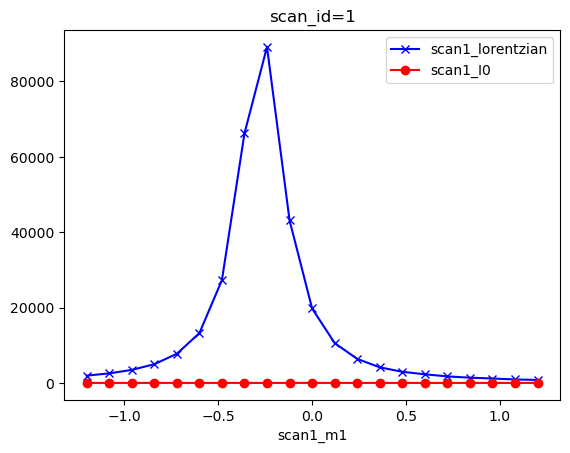

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

x = dataset["scan1_m1"]
y1 = dataset["scan1_lorentzian"]
y2 = dataset["scan1_I0"]

plt.plot(x.values, y1.values, "bx-", label=y1.name)
plt.plot(x.values, y2.values, "ro-", label=y2.name)
plt.xlabel(x.name)
plt.title(f"scan_id={run.metadata['start']['scan_id']}")
plt.legend()